# IMPORT LIBRARIES

In [1]:
import pandas as pd

import numpy as np

import itertools

from datetime import datetime

import time

import pytz
import sys
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, max_error, r2_score

import seaborn as sns

import matplotlib.pyplot as plt

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

# CONFIGURATION

In [2]:
sOutputSymbol = 'BTCUSD'
sModelType = 'MLP'

iTrialId = 36

In [3]:
dfCciDesign = pd.read_csv('Data\Cci Design_'+ sOutputSymbol +'_'+ sModelType +'.csv', index_col = 0)
iBatchSize = dfCciDesign.loc[iTrialId, 'iBatchSize']
iNrOfHiddenNeurons = dfCciDesign.loc[iTrialId, 'iNrOfHiddenNeurons']
iBackwardTimeWindow = dfCciDesign.loc[iTrialId, 'iBackwardTimeWindow']
iForwardTimeWindow = dfCciDesign.loc[iTrialId, 'iForwardTimeWindow']

In [4]:
sModelName = os.path.join(sOutputSymbol , sModelType + '_' + str(iTrialId))

# LOAD DATA

## Cryptocurrency List

In [5]:
dfCrpytocurrencies = pd.read_csv('Data\cryptocurrencies.csv')
dfCrpytocurrencies.head()

,Symbol
0,BTCUSD
1,ETHUSD
2,BCHUSD
3,LTCUSD
4,RPLUSD


## Market Data

In [6]:
dfOhlc = pd.read_csv('Data\dfOhlc.csv')
dfOhlc['timestamp'] = pd.DatetimeIndex(dfOhlc['timestamp'])
dfOhlc.set_index('timestamp', inplace=True)

# PREPROCESSING

## Split Data

In [7]:
fTrainingRatio = 0.7
fValidationRatio = 0.15
fTestRatio = 0.15

ixTrain, ixTest = train_test_split(
    dfOhlc.index,
    test_size=1-fTrainingRatio,
    shuffle=False)

ixValidation, ixTest = train_test_split(
    ixTest,
    test_size=fTestRatio/(fTestRatio + fValidationRatio),
    shuffle=False)

## Scale Data

In [8]:
dfScaledOhlc = pd.DataFrame(index = dfOhlc.index, columns  = dfOhlc.columns)

for sColumn in dfOhlc.columns:
    oScaler = StandardScaler()
    
    dfTrain = pd.DataFrame(dfOhlc.loc[ixTrain, sColumn])
    dfValidation = pd.DataFrame(dfOhlc.loc[ixValidation, sColumn])
    dfTest = pd.DataFrame(dfOhlc.loc[ixTest, sColumn])
    
    oScaler.fit(dfTrain.append(dfValidation))
    
    dfScaledOhlc.loc[ixTrain, sColumn] = np.reshape(oScaler.transform(dfTrain), (-1))
    dfScaledOhlc.loc[ixValidation, sColumn] = np.reshape(oScaler.transform(dfValidation), (-1))
    dfScaledOhlc.loc[ixTest, sColumn] = np.reshape(oScaler.transform(dfTest), (-1))

    sScalerFilePath = os.path.join(sModelName , "__scalers__")
    sScalerFilePath = os.path.join(sScalerFilePath , sColumn + ".sav")
    os.makedirs(os.path.dirname(sScalerFilePath), exist_ok=True)
    
    pickle.dump(oScaler, open(sScalerFilePath, 'wb'))

## Input Dataset

In [9]:
aInputSymbols = dfCrpytocurrencies['Symbol'].values
aInputFeatures = ['weekday', 'hour', 'minute' ,'upper_shadow', 'lower_shadow' ,'return']
aInputFeatures = list(map(":".join, itertools.product(aInputSymbols, aInputFeatures)))

iNrInputFeatures = len(aInputFeatures)

aBackwardTimeSteps = range(-iBackwardTimeWindow, 0)

aTplInputColumns = list(itertools.product(aBackwardTimeSteps, aInputFeatures))
aIxInputColumns = pd.MultiIndex.from_tuples(aTplInputColumns, names= ['time_step', 'feature'])

dfInput = pd.DataFrame(columns = aIxInputColumns)

for tplColumn in list(dfInput.columns):
    dfInput.loc[:, tplColumn] = dfScaledOhlc[(tplColumn[1])].shift(-tplColumn[0])

    
ixNas = dfInput[dfInput.isna().any(axis=1)].index
dfInput.drop(ixNas, inplace = True, errors = 'ignore') 
ixTrain= ixTrain.drop(ixNas, errors = 'ignore') 
ixValidation= ixValidation.drop(ixNas,   errors = 'ignore') 
ixTest = ixTest.drop(ixNas,   errors = 'ignore') 

dfInput.head()

time_step                       -5                            \
feature             BTCUSD:weekday BTCUSD:hour BTCUSD:minute   
timestamp                                                      
2021-09-01 02:30:00      -0.003076   -1.662613          -1.0   
2021-09-01 03:00:00      -0.003076   -1.662613           1.0   
2021-09-01 03:30:00      -0.003076   -1.517929          -1.0   
2021-09-01 04:00:00      -0.003076   -1.517929           1.0   
2021-09-01 04:30:00      -0.003076   -1.373245          -1.0   

time_step                                                                  \
feature             BTCUSD:upper_shadow BTCUSD:lower_shadow BTCUSD:return   
timestamp                                                                   
2021-09-01 02:30:00            0.272382           -0.344248      0.367626   
2021-09-01 03:00:00            1.482079           -0.838114     -0.274886   
2021-09-01 03:30:00             0.09279           -0.050609     -0.230078   
2021-09-01 04:00:00           -0.792066           -0.003061      0.948749   
2021-09-01 04:30:00           -0.402557           -0.069069      0.438649   

time_step                                                     \
feature             ETHUSD:weekday ETHUSD:hour ETHUSD:minute   
timestamp                                                      
2021-09-01 02:30:00      -0.003076   -1.662613          -1.0   
2021-09-01 03:00:00      -0.003076   -1.662613           1.0   
2021-09-01 03:30:00      -0.003076   -1.517929          -1.0   
2021-09-01 04:00:00      -0.003076   -1.517929           1.0   
2021-09-01 04:30:00      -0.003076   -1.373245          -1.0   

time_step                                ...            -1  \
feature             ETHUSD:upper_shadow  ... LTCUSD:minute   
timestamp                                ...                 
2021-09-01 02:30:00            0.101196  ...          -1.0   
2021-09-01 03:00:00            2.108089  ...           1.0   
2021-09-01 03:30:00              0.5739  ...          -1.0   
2021-09-01 04:00:00           -0.693713  ...           1.0   
2021-09-01 04:30:00           -0.541873  ...          -1.0   

time_step                                                                  \
feature             LTCUSD:upper_shadow LTCUSD:lower_shadow LTCUSD:return   
timestamp                                                                   
2021-09-01 02:30:00           -0.849824           -0.029284      0.450547   
2021-09-01 03:00:00            0.508944           -0.675575      0.071885   
2021-09-01 03:30:00            1.236206            0.260103     -0.531665   
2021-09-01 04:00:00            -0.84953           -0.301025      -0.95781   
2021-09-01 04:30:00           -0.597665            0.115612      0.283424   

time_step                                                     \
feature             RPLUSD:weekday RPLUSD:hour RPLUSD:minute   
timestamp                                                      
2021-09-01 02:30:00      -0.003076   -1.373245          -1.0   
2021-09-01 03:00:00      -0.003076   -1.373245           1.0   
2021-09-01 03:30:00      -0.003076   -1.228561          -1.0   
2021-09-01 04:00:00      -0.003076   -1.228561           1.0   
2021-09-01 04:30:00      -0.003076   -1.083877          -1.0   

time_step                                                                  
feature             RPLUSD:upper_shadow RPLUSD:lower_shadow RPLUSD:return  
timestamp                                                                  
2021-09-01 02:30:00            0.136139            1.074724      0.541948  
2021-09-01 03:00:00            3.148526            -0.76391      0.835947  
2021-09-01 03:30:00            2.070256            2.147994      0.002064  
2021-09-01 04:00:00           -0.825667           -0.338218     -2.538037  
2021-09-01 04:30:00            -0.51259             0.08902      0.969554  

[5 rows x 150 columns]

## Output Dataset

In [10]:
aOutputFeatures = ['return']
aOutputFeatures = list(map(":".join, itertools.product([sOutputSymbol], aOutputFeatures)))
iNrOutputFeatures = len(aOutputFeatures)

aForwardTimeSteps = range(0, iForwardTimeWindow)


aTplOutputColumns = list(itertools.product(aForwardTimeSteps, aOutputFeatures))
aIxOutputColumns = pd.MultiIndex.from_tuples(aTplOutputColumns, names= ['time_step', 'feature'])

dfOutput = pd.DataFrame(columns = aIxOutputColumns)

for tplColumn in list(dfOutput.columns):
    dfOutput.loc[:, tplColumn] =  dfOhlc[(tplColumn[1])].shift(-tplColumn[0])

ixNas = dfOutput[dfOutput.isna().any(axis=1)].index
dfOutput.drop(ixNas, inplace = True, errors = 'ignore') 
ixTrain= ixTrain.drop(ixNas, errors = 'ignore') 
ixValidation= ixValidation.drop(ixNas,   errors = 'ignore') 
ixTest = ixTest.drop(ixNas,   errors = 'ignore') 
dfOutput.head()

time_step,0,1,2,3,4,5
feature,BTCUSD:return,BTCUSD:return,BTCUSD:return,BTCUSD:return,BTCUSD:return,BTCUSD:return
timestamp,,,,,,
2021-09-01 00:00:00,0.001941,-0.001465,-0.001227,0.005021,0.002318,-0.002022
2021-09-01 00:30:00,-0.001465,-0.001227,0.005021,0.002318,-0.002022,-0.001229
2021-09-01 01:00:00,-0.001227,0.005021,0.002318,-0.002022,-0.001229,-0.006108
2021-09-01 01:30:00,0.005021,0.002318,-0.002022,-0.001229,-0.006108,-0.002300
2021-09-01 02:00:00,0.002318,-0.002022,-0.001229,-0.006108,-0.002300,0.004327


## Reshape Datasets

In [11]:
axMerged = dfInput.index.join(dfOutput.index, how = 'inner')

dfInput = dfInput.loc[axMerged]
dfOutput = dfOutput.loc[axMerged]

ixTrain = ixTrain.join(axMerged, how = "inner")
ixValidation = ixValidation.join(axMerged, how = "inner")
ixTest = ixTest.join(axMerged, how = "inner")

In [12]:
dfInputTrain = dfInput.loc[ixTrain]
aInputTrain = np.reshape(dfInputTrain.values, (dfInputTrain.shape[0], iBackwardTimeWindow, iNrInputFeatures))

dfInputValidation = dfInput.loc[ixValidation]
aInputValidation = np.reshape(dfInputValidation.values, (dfInputValidation.shape[0], iBackwardTimeWindow, iNrInputFeatures))

dfInputTest = dfInput.loc[ixTest]
aInputTest = np.reshape(dfInputTest.values, (dfInputTest.shape[0], iBackwardTimeWindow, iNrInputFeatures))

dfOutputTrain = dfOutput.loc[ixTrain]
aOutputTrain = np.reshape(dfOutputTrain.values, (dfOutputTrain.shape[0], iForwardTimeWindow, iNrOutputFeatures))

dfOutputValidation = dfOutput.loc[ixValidation]
aOutputValidation = np.reshape(dfOutputValidation.values, (dfOutputValidation.shape[0], iForwardTimeWindow, iNrOutputFeatures))

dfOutputTest = dfOutput.loc[ixTest]
aOutputTest = np.reshape(dfOutputTest.values, (dfOutputTest.shape[0], iForwardTimeWindow, iNrOutputFeatures))

In [13]:
aInputTrain = np.asarray(aInputTrain, np.float32)
aInputValidation = np.asarray(aInputValidation, np.float32)
aInputTest = np.asarray(aInputTest, np.float32)
aOutputTrain = np.asarray(aOutputTrain, np.float32)
aOutputValidation = np.asarray(aOutputValidation, np.float32)
aOutputTest = np.asarray(aOutputTest, np.float32)

#  MODEL DEVELOPMENT

## Set Hyperparameters

In [14]:
iEpochSize = 10000
oEarlyStop = EarlyStopping(
    monitor = 'val_loss', 
    mode = 'min', 
    verbose = 0 , 
    patience = 20, 
    restore_best_weights = True)

## Define Custom Loss Function

While loss function is defined following criteria is taken into consideration:
1. Opposite signs should be penalized.
1. Opposite sings will be worse when the magnitute of error increases.
1. Any of same sign is better than any of the opposite signs.
1. Same sign is the best when the error is 0.

Following logic also should have been implemented but it was unsuccessful to implement due to forcing negative errors. It will be used as 'metric' function.
1. Same sign is positive error is better than negative error (err = act - pred )

In [15]:
def fCalculateLoss(aActual, aPrediction):
    aLossDueToError = tf.math.subtract(aActual ,aPrediction)
    aLossDueToError = tf.math.abs(aLossDueToError)
    
    fPenalty = tf.math.reduce_max(aLossDueToError)
    
    aLossDueToSignDiff = tf.math.abs(tf.math.subtract(tf.math.sign(aActual), tf.math.sign(aPrediction)) )
    aLossDueToSignDiff = tf.where(aLossDueToSignDiff == 0, aLossDueToSignDiff, fPenalty)
    
    aTotalLoss = aLossDueToError + aLossDueToSignDiff
        
    return tf.math.reduce_mean(aTotalLoss)

## Build Model

### MLP

In [16]:
if sModelType == 'MLP':
    aInputMlp = keras.Input(
        shape=(iBackwardTimeWindow, iNrInputFeatures))

    aW = keras.layers.Flatten()(aInputMlp)
    aW = keras.layers.Dense(iNrOfHiddenNeurons)(aW)
    aW = keras.layers.Dense(iForwardTimeWindow*iNrOutputFeatures)(aW)
    aW = keras.layers.Reshape((iForwardTimeWindow, iNrOutputFeatures))(aW)

    aOutputMlp = aW
    oModelMlp = keras.Model(
        inputs=aInputMlp,
        outputs=aOutputMlp
    )

    oOptimizerMlp = tf.keras.optimizers.Adam(learning_rate=1e-04)
    oModelMlp.compile(optimizer=oOptimizerMlp,
                             loss = fCalculateLoss
                            )

    oPredictiveModel = oModelMlp

    tf.keras.utils.plot_model(oModelMlp,  show_shapes=True, to_file=sModelName +'\Model architecture.png')

### LSTM

In [17]:
if sModelType == 'LSTM':
    aInputDeepLstm = keras.Input(
        shape=(iBackwardTimeWindow, iNrInputFeatures))

    aW = keras.layers.LSTM(64, return_sequences = True)(aInputDeepLstm)
    aW = keras.layers.Flatten()(aW)
    aW = keras.layers.Dense(iForwardTimeWindow*iNrOutputFeatures)(aW)
    aW = keras.layers.Reshape((iForwardTimeWindow, iNrOutputFeatures))(aW)

    aOutputDeepLstm = aW
    oModelDeepLstm = keras.Model(
        inputs=aInputDeepLstm,
        outputs=aOutputDeepLstm
    )

    oOptimizerDeepLstm = tf.keras.optimizers.Adam(learning_rate=1e-04)
    oModelDeepLstm.compile(optimizer=oOptimizerDeepLstm,
                             loss = fCalculateLoss
                            )

    oPredictiveModel = oModelDeepLstm

    tf.keras.utils.plot_model(oModelDeepLstm,  show_shapes=True, to_file=sModelName+'\Model architecture.png')

### Deep CNN

In [18]:
if sModelType == 'Deep CNN':
    aInputDeepCnn = keras.Input(
        shape=(iBackwardTimeWindow, iNrInputFeatures))

    aW = keras.layers.LSTM(64, return_sequences = True)(aInputDeepCnn)
    aW = keras.layers.Flatten()(aW)
    aW = keras.layers.Dense(iNrOfBins*iForwardTimeWindow*iNrOutputFeatures)(aW)
    aW = keras.layers.Reshape((iNrOutputFeatures * iNrOfBins, iForwardTimeWindow, 1))(aW)
    aW = keras.layers.Conv2D(64, (4,4), (1,1), padding = "same" )(aW)
    aW = keras.layers.MaxPool2D(pool_size = (4, 4))(aW)
    aW = keras.layers.Flatten()(aW)
    aW = keras.layers.Dense(iNrOfBins*iForwardTimeWindow*iNrOutputFeatures)(aW)
    aW = keras.layers.Reshape((iNrOutputFeatures, iNrOfBins, iForwardTimeWindow))(aW)

    aOutputDeepCnn = aW
    oModelDeepCnn = keras.Model(
        inputs=aInputDeepCnn,
        outputs=aOutputDeepCnn
    )

    oOptimizerDeepCnn = tf.keras.optimizers.Adam(learning_rate=1e-05)
    oModelDeepCnn.compile(optimizer=oOptimizerDeepCnn,
                             loss = fCalculateLoss
                            )

    tf.keras.utils.plot_model(oModelDeepCnn,  show_shapes=True, to_file=sModelName+'\Model architecture.png')

### Convolutional Encoder-Decoder Model

In [19]:
if sModelType == 'Convolutional Encoder Decoder':
    aInputs = keras.Input(
        shape=(iBackwardTimeWindow, iNrInputFeatures))

    aEncoderHiddens, aFinalH, aFinalC = keras.layers.LSTM(iNrOfHiddenNeurons,
                                             return_state = True, 
                                             return_sequences = True
                                            )(aInputs)
    aFinalH = keras.layers.BatchNormalization()(aFinalH)
    aFinalC = keras.layers.BatchNormalization()(aFinalC)

    aFeatureMap = keras.layers.Conv1D(64, 2)(aEncoderHiddens)
    aFeatureMap = keras.layers.MaxPooling1D(2)(aFeatureMap)
    aFlatted = keras.layers.Flatten()(aFeatureMap)

    aDecoderInputs = keras.layers.RepeatVector(iForwardTimeWindow)(aFlatted)

    aDecoderHiddens = keras.layers.LSTM(iNrOfHiddenNeurons, 
                           return_state = False, 
                           return_sequences = True
                          )(aDecoderInputs, initial_state=[aFinalH, aFinalC])


    aOutputs = keras.layers.TimeDistributed(
        Dense(iNrOutputFeatures)
    )(aDecoderHiddens)

    oPredictiveModel = keras.Model(
        inputs=aInputs,
        outputs=aOutputs
    )

    oOptimizer = tf.keras.optimizers.Adam(learning_rate=1e-05)
    oPredictiveModel.compile(loss = fCalculateLoss,
                             optimizer=oOptimizer
                            )

    tf.keras.utils.plot_model(oPredictiveModel,  show_shapes=True, to_file=sModelName+'\Model architecture.png')

### Luong's Attention Model

In [20]:
if sModelType == 'Luongs Attention':
    aEncoderInputs = keras.Input(
        shape=(iBackwardTimeWindow, iNrInputFeatures))

    aEncoderHiddens, aFinalH, aFinalC = keras.layers.LSTM(iNrOfHiddenNeurons,
                                             return_state = True, 
                                             return_sequences = True
                                            )(aEncoderInputs)
    aFinalH = keras.layers.BatchNormalization()(aFinalH)
    aFinalC = keras.layers.BatchNormalization()(aFinalC)

    aDecoderInputs = keras.layers.RepeatVector(iForwardTimeWindow)(aFinalH)

    aDecoderHiddens = keras.layers.LSTM(iNrOfHiddenNeurons, 
                           return_state = False, 
                           return_sequences = True
                          )(aDecoderInputs, initial_state=[aFinalH, aFinalC])

    aAttentions = keras.layers.dot([aDecoderHiddens, aEncoderHiddens], axes=[2, 2])
    aAttentions = keras.layers.Activation('softmax')(aAttentions)

    aContextVector = keras.layers.dot([aAttentions, aEncoderHiddens], axes=[2,1])
    aContextVector = keras.layers.BatchNormalization()(aContextVector)
    aContextVector = keras.layers.concatenate([aContextVector, aDecoderHiddens])

    aDecoderOutputs = keras.layers.TimeDistributed(
        Dense(iNrOutputFeatures)
    )(aContextVector)

    oPredictiveModel = keras.Model(
        inputs=aEncoderInputs,
        outputs=aDecoderOutputs
    )

    oOptimizer = tf.keras.optimizers.Adam(learning_rate=1e-05)
    oPredictiveModel.compile(loss = fCalculateLoss, 
                             optimizer=oOptimizer
                            )

    tf.keras.utils.plot_model(oPredictiveModel,  show_shapes=True+'\Model architecture.png')

## Fit Model

In [21]:
dtStartTime = time.time()
oPredictiveModel.fit(
    aInputTrain, 
    aOutputTrain, 
    epochs=iEpochSize, 
    batch_size=iBatchSize, 
    verbose=1, 
    validation_data= (aInputValidation, aOutputValidation),
    validation_batch_size= iBatchSize
    ,callbacks=[oEarlyStop]
)
dtEndTime = time.time()
dtTrainingDuration = dtEndTime -dtStartTime

Epoch 1/10000
16/16 [==============================] - 1s 21ms/step - loss: 4.5886 - val_loss: 3.0757
Epoch 2/10000
16/16 [==============================] - 0s 4ms/step - loss: 3.8429 - val_loss: 2.8195
Epoch 3/10000
16/16 [==============================] - 0s 3ms/step - loss: 3.4503 - val_loss: 2.6335
Epoch 4/10000
16/16 [==============================] - 0s 4ms/step - loss: 3.0808 - val_loss: 2.4371
Epoch 5/10000
16/16 [==============================] - 0s 4ms/step - loss: 2.9652 - val_loss: 2.3216
Epoch 6/10000
16/16 [==============================] - 0s 4ms/step - loss: 2.7783 - val_loss: 2.2857
Epoch 7/10000
16/16 [==============================] - 0s 4ms/step - loss: 2.5823 - val_loss: 2.2109
Epoch 8/10000
16/16 [==============================] - 0s 4ms/step - loss: 2.5652 - val_loss: 2.1012
Epoch 9/10000
16/16 [==============================] - 0s 3ms/step - loss: 2.4214 - val_loss: 2.0422
Epoch 10/10000
16/16 [==============================] - 0s 3ms/step - loss: 2.2660 - val_l

## Model Epochs

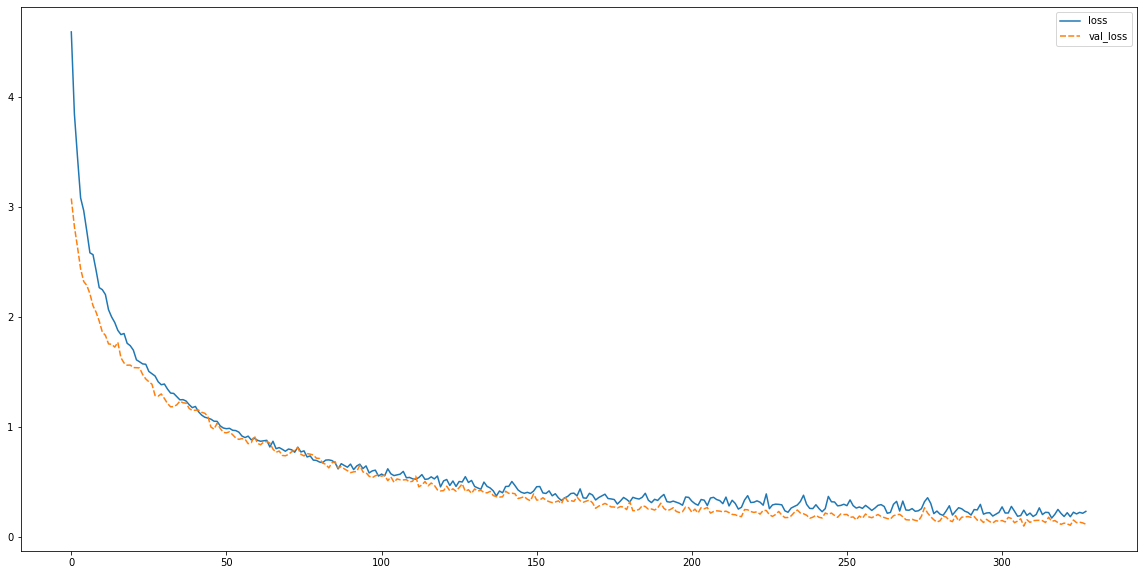

In [22]:
plt.figure(figsize = (20,10))
oFig = sns.lineplot(data = pd.DataFrame(oPredictiveModel.history.history))
oFig.get_figure().savefig(sModelName + '\epochs.png')

## Save Model

In [23]:
oPredictiveModel.save_weights(sModelName+'\model weights')

## Test Model

In [24]:
oPredictiveModel.load_weights(sModelName+'\model weights')

aPrediction = oPredictiveModel.predict(aInputTest)
aPrediction = aPrediction.reshape((-1, iForwardTimeWindow * iNrOutputFeatures))
dfPrediction = pd.DataFrame(data = aPrediction, index = ixTest, columns = aIxOutputColumns)

aActual = aOutputTest.reshape((-1, iForwardTimeWindow * iNrOutputFeatures))
dfActual =  pd.DataFrame(data = aActual, index = ixTest, columns = aIxOutputColumns).copy()

## Save Results

In [25]:
dfActual.to_csv(sModelName + '\dfActual.csv')
dfPrediction.to_csv(sModelName + '\dfPrediction.csv')

In [26]:
dfPerformance = pd.DataFrame(data = [dtTrainingDuration], columns = ['value'], index = ['training duration'] )
dfPerformance.to_csv(sModelName + '\dfPerformance.csv')

# REFERENCES

https://www.tensorflow.org/guide/keras/train_and_evaluate#passing_data_to_multi-input_multi-output_models

https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch/

https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit/

https://towardsdatascience.com/customize-loss-function-to-make-lstm-model-more-applicable-in-stock-price-prediction-b1c50e50b16c

https://keras.io/getting_started/faq/

https://machinelearningmastery.com/how-to-develop-lstm-models-for-multi-step-time-series-forecasting-of-household-power-consumption/

https://www.tensorflow.org/tutorials/structured_data/time_series

https://towardsdatascience.com/encoder-decoder-model-for-multistep-time-series-forecasting-using-pytorch-5d54c6af6e60

https://levelup.gitconnected.com/building-seq2seq-lstm-with-luong-attention-in-keras-for-time-series-forecasting-1ee00958decb